In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [222]:
df_tck = pd.read_csv('results/params/t_ckt.csv')
df_Tc = pd.read_csv('results/params/T_c.csv')
df_Tk = pd.read_csv('results/params/T_k.csv')
df_phi = pd.read_csv('../data/processed/city_rent.csv')
df_mj = pd.read_csv('results/params/major_params.csv')

df_tck = df_tck[df_tck['city_year'].astype(str).str.endswith('2019')]
df_Tc = df_Tc[df_Tc['city_year'].astype(str).str.endswith('2019')]
df_Tk = df_Tk[df_Tk['occ_year'].astype(str).str.endswith('2019')]
df_phi = df_phi[['city', '2019']]

df_phi = df_phi.rename(columns={'2019': 'phi'})

df_tck['city'] = df_tck['city_year'].str.split('_').str[0].str.replace(r'[()]', '', regex=True)
df_tck['occ'] = df_tck['occ_year'].str.extract(r'\((.*?)\)')[0]
df_Tc['city'] = df_Tc['city_year'].str.split('_').str[0].str.replace(r'[()]', '', regex=True)
df_Tk['occ'] = df_Tk['occ_year'].str.extract(r'\((.*?)\)')[0]

df_tck = df_tck[['city', 'occ', 't_ckt']]
df_Tc = df_Tc[['city', 'T_c']]
df_Tk = df_Tk[['occ', 'T_k']]

In [223]:
z_c = df_Tc.copy()
z_c = z_c.merge(df_phi, on='city')
z_c['z_c'] = z_c['T_c'] / z_c['phi']
z_c = z_c.drop(columns=['T_c', 'phi'])
z_c['z_c'] = z_c['z_c'].apply(lambda x: x ** (- df_mj['theta'].values[0]))

In [224]:
lambda_k = df_tck.copy()
lambda_k = lambda_k.merge(z_c, on='city')
lambda_k['t_ckt'] = lambda_k['t_ckt'] * lambda_k['z_c']
lambda_k = lambda_k.drop(columns=['z_c'])
lambda_k = lambda_k.groupby('occ').sum().reset_index()
lambda_k = lambda_k.drop(columns=['city'])
lambda_k = lambda_k[~lambda_k['occ'].str.contains('city_total')]
lambda_k = lambda_k.rename(columns={'t_ckt': 'lambda_k'})

In [225]:
pi_ck = df_tck.copy()
pi_ck = pi_ck.merge(z_c, on='city')
pi_ck['t_ckt'] = pi_ck['t_ckt'] * pi_ck['z_c']
pi_ck = pi_ck.drop(columns=['z_c'])

pi_ck['t_ckt'] = pi_ck['t_ckt'].apply(lambda x: x ** (1 / (1 - df_mj['rho'][0])))
pi_ck = pi_ck.merge(lambda_k, on='occ')
pi_ck['pi_ck'] = pi_ck['t_ckt'] / pi_ck['lambda_k']
pi_ck = pi_ck.drop(columns=['t_ckt', 'lambda_k'])
pi_ck = pi_ck.pivot(index='city', columns='occ', values='pi_ck').reset_index()

In [226]:
pi_c = df_tck.copy()
pi_c = pi_c.merge(z_c, on='city')
pi_c['t_ckt'] = pi_c['t_ckt'] * pi_c['z_c']
pi_c = pi_c.drop(columns=['z_c'])
pi_c = pi_c.merge(lambda_k, on='occ')

omega = df_Tk.copy()
omega = omega.merge(lambda_k, on='occ')
omega['lambda_k'] = omega['lambda_k'].apply(lambda x: x ** (1 - df_mj['rho'][0]))
omega['T_k'] = omega['T_k'] * omega['lambda_k']
omega = omega.drop(columns=['lambda_k'])
omega['omega'] = omega['T_k'] / omega['T_k'].sum()
omega = omega.drop(columns=['T_k'])
old_omega = omega.copy()
old_omega.rename(columns={'omega': 'old_omega'}, inplace=True)

pi_c['t_ckt'] = pi_c['t_ckt'].apply(lambda x: x ** (1 / (1 - df_mj['rho'][0])))
pi_c['t_ckt'] = pi_c['t_ckt'] / pi_c['lambda_k']
pi_c = pi_c.drop(columns=['lambda_k'])
pi_c = pi_c.merge(omega, on='occ')
pi_c['old_pi_c'] = pi_c['t_ckt'] * pi_c['omega']
pi_c = pi_c.drop(columns=['t_ckt', 'omega'])
pi_c = pi_c.groupby('city').sum().reset_index()
old_pi_c = pi_c.drop(columns=['occ'])

In [227]:
# New York-Newark-Jersey City, NY-NJ-PA

z_c = df_Tc.copy()
z_c = z_c.merge(df_phi, on='city')
z_c.loc[z_c['city'] == 'New York-Newark-Jersey City, NY-NJ-PA', 'T_c'] *= 0.5
z_c['z_c'] = z_c['T_c'] / z_c['phi']
z_c = z_c.drop(columns=['T_c', 'phi'])
z_c['z_c'] = z_c['z_c'].apply(lambda x: x ** (- df_mj['theta'].values[0]))

lambda_k = df_tck.copy()
lambda_k = lambda_k.merge(z_c, on='city')
lambda_k['t_ckt'] = lambda_k['t_ckt'] * lambda_k['z_c']
lambda_k = lambda_k.drop(columns=['z_c'])
lambda_k = lambda_k.groupby('occ').sum().reset_index()
lambda_k = lambda_k.drop(columns=['city'])
lambda_k = lambda_k[~lambda_k['occ'].str.contains('city_total')]
lambda_k = lambda_k.rename(columns={'t_ckt': 'lambda_k'})

pi_c = df_tck.copy()
pi_c = pi_c.merge(z_c, on='city')
pi_c['t_ckt'] = pi_c['t_ckt'] * pi_c['z_c']
pi_c = pi_c.drop(columns=['z_c'])
pi_c = pi_c.merge(lambda_k, on='occ')

omega = df_Tk.copy()
omega = omega.merge(lambda_k, on='occ')
omega['lambda_k'] = omega['lambda_k'].apply(lambda x: x ** (1 - df_mj['rho'][0]))
omega['T_k'] = omega['T_k'] * omega['lambda_k']
omega = omega.drop(columns=['lambda_k'])
omega['omega'] = omega['T_k'] / omega['T_k'].sum()
omega = omega.drop(columns=['T_k'])

pi_c['t_ckt'] = pi_c['t_ckt'].apply(lambda x: x ** (1 / (1 - df_mj['rho'][0])))
pi_c['t_ckt'] = pi_c['t_ckt'] / pi_c['lambda_k']
pi_c = pi_c.drop(columns=['lambda_k'])
pi_c = pi_c.merge(omega, on='occ')
pi_c['new_pi_c'] = pi_c['t_ckt'] * pi_c['omega']
pi_c = pi_c.drop(columns=['t_ckt', 'omega'])
pi_c = pi_c.groupby('city').sum().reset_index()
new_pi_c = pi_c.drop(columns=['occ'])

change = new_pi_c.merge(old_pi_c, on='city')
change['change'] = ((change['new_pi_c'] / change['old_pi_c']) - 1) * 100
change = change.sort_values('change', ascending=False).reset_index(drop=True)
change['city'] = change['city'].str.split(',').str[0]
change[['city', 'change']].head(10).to_latex('tables/city_counter.tex', index=False)

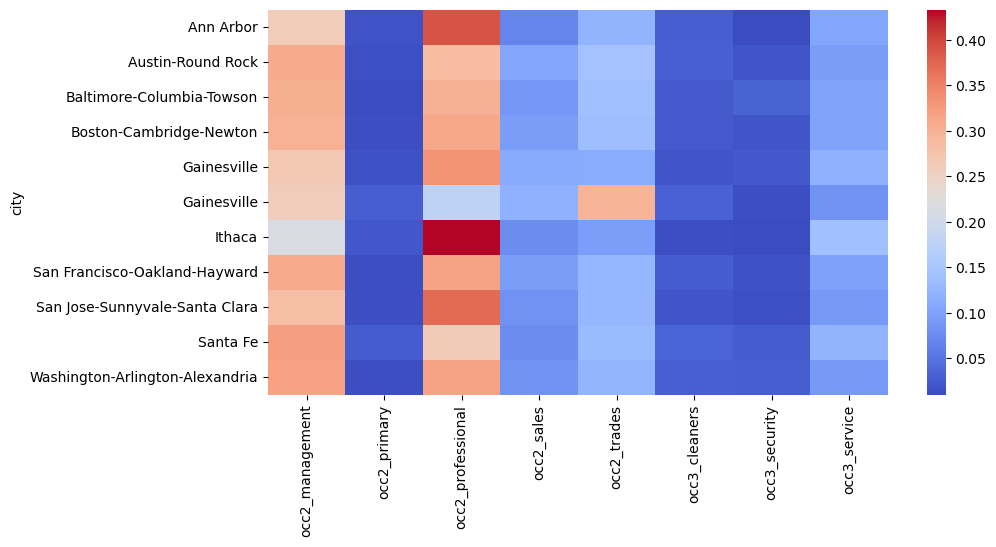

In [228]:
city_comp = pd.read_csv('../data/processed/city_occ_employment/city_occ_e_2019.csv')
city_comp['MET2013'] = city_comp['MET2013'].str.split(',').str[0]
city_comp = city_comp[city_comp['MET2013'].isin(change['city'].iloc[:10])]
city_comp.rename(columns={'MET2013': 'city'}, inplace=True)
city_comp.set_index('city', inplace=True)
city_comp['city_total'] = city_comp.sum(axis=1)
city_comp = city_comp.div(city_comp['city_total'], axis=0)
city_comp.drop(columns=['city_total'], inplace=True)

plt.figure(figsize=(10, 5))
sns.heatmap(city_comp, annot=False, cmap='coolwarm', cbar_kws={'label': ''})
plt.savefig('graphs/ny_counter.png', bbox_inches='tight')

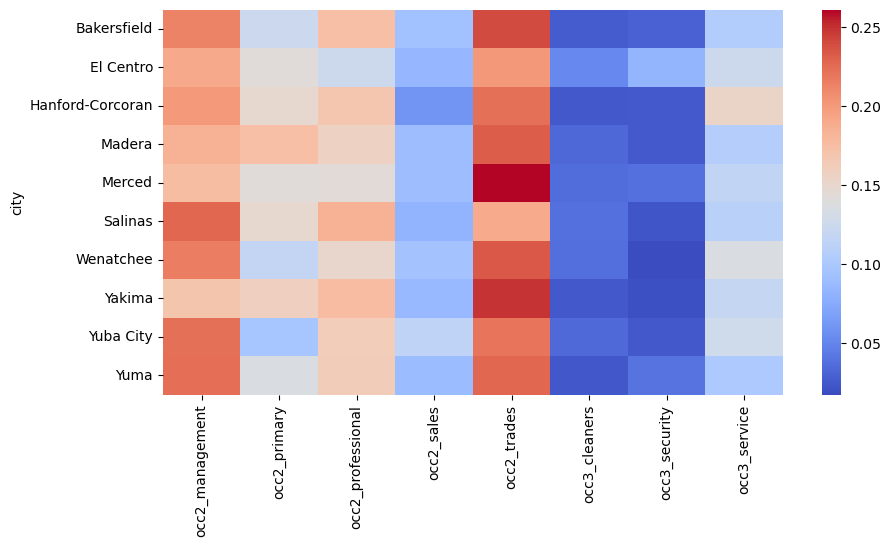

In [229]:
# Visalia-Porterville, CA

z_c = df_Tc.copy()
z_c = z_c.merge(df_phi, on='city')
z_c.loc[z_c['city'] == 'Visalia-Porterville, CA', 'T_c'] *= 0.5
z_c['z_c'] = z_c['T_c'] / z_c['phi']
z_c = z_c.drop(columns=['T_c', 'phi'])
z_c['z_c'] = z_c['z_c'].apply(lambda x: x ** (- df_mj['theta'].values[0]))

lambda_k = df_tck.copy()
lambda_k = lambda_k.merge(z_c, on='city')
lambda_k['t_ckt'] = lambda_k['t_ckt'] * lambda_k['z_c']
lambda_k = lambda_k.drop(columns=['z_c'])
lambda_k = lambda_k.groupby('occ').sum().reset_index()
lambda_k = lambda_k.drop(columns=['city'])
lambda_k = lambda_k[~lambda_k['occ'].str.contains('city_total')]
lambda_k = lambda_k.rename(columns={'t_ckt': 'lambda_k'})

pi_c = df_tck.copy()
pi_c = pi_c.merge(z_c, on='city')
pi_c['t_ckt'] = pi_c['t_ckt'] * pi_c['z_c']
pi_c = pi_c.drop(columns=['z_c'])
pi_c = pi_c.merge(lambda_k, on='occ')

omega = df_Tk.copy()
omega = omega.merge(lambda_k, on='occ')
omega['lambda_k'] = omega['lambda_k'].apply(lambda x: x ** (1 - df_mj['rho'][0]))
omega['T_k'] = omega['T_k'] * omega['lambda_k']
omega = omega.drop(columns=['lambda_k'])
omega['omega'] = omega['T_k'] / omega['T_k'].sum()
omega = omega.drop(columns=['T_k'])

pi_c['t_ckt'] = pi_c['t_ckt'].apply(lambda x: x ** (1 / (1 - df_mj['rho'][0])))
pi_c['t_ckt'] = pi_c['t_ckt'] / pi_c['lambda_k']
pi_c = pi_c.drop(columns=['lambda_k'])
pi_c = pi_c.merge(omega, on='occ')
pi_c['new_pi_c'] = pi_c['t_ckt'] * pi_c['omega']
pi_c = pi_c.drop(columns=['t_ckt', 'omega'])
pi_c = pi_c.groupby('city').sum().reset_index()
new_pi_c = pi_c.drop(columns=['occ'])

change = new_pi_c.merge(old_pi_c, on='city')
change['change'] = ((change['new_pi_c'] / change['old_pi_c']) - 1) * 100
change = change.sort_values('change', ascending=False).reset_index(drop=True)
change['city'] = change['city'].str.split(',').str[0]
# change[['city', 'change']].head(10).to_latex('tables/city_counter.tex', index=False)

city_comp = pd.read_csv('../data/processed/city_occ_employment/city_occ_e_2019.csv')
city_comp['MET2013'] = city_comp['MET2013'].str.split(',').str[0]
city_comp = city_comp[city_comp['MET2013'].isin(change['city'].iloc[:10])]
city_comp.rename(columns={'MET2013': 'city'}, inplace=True)
city_comp.set_index('city', inplace=True)
city_comp['city_total'] = city_comp.sum(axis=1)
city_comp = city_comp.div(city_comp['city_total'], axis=0)
city_comp.drop(columns=['city_total'], inplace=True)

plt.figure(figsize=(10, 5))
sns.heatmap(city_comp, annot=False, cmap='coolwarm', cbar_kws={'label': ''})
plt.savefig('graphs/vp_counter.png', bbox_inches='tight')

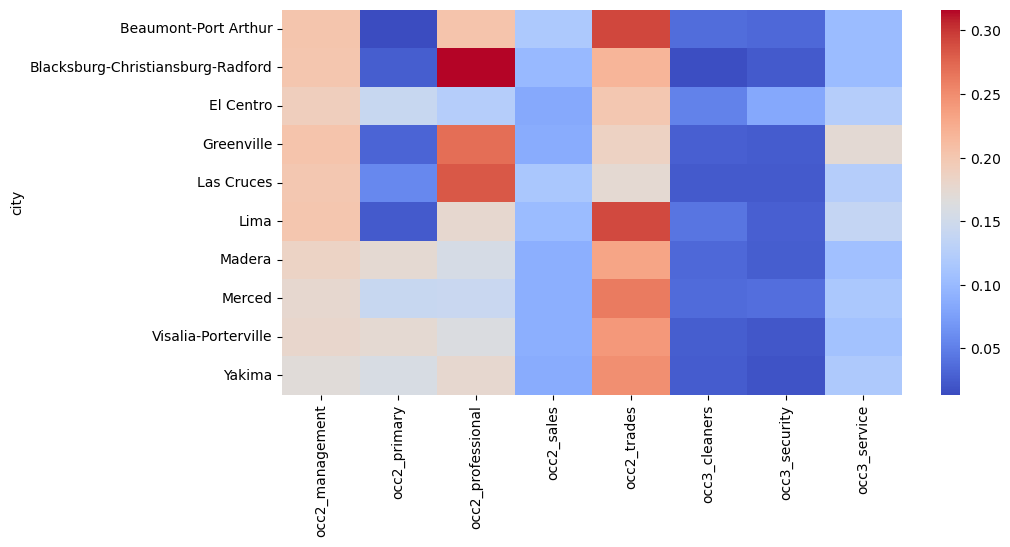

In [230]:
# Management Occupations

z_c = df_Tc.copy()
z_c = z_c.merge(df_phi, on='city')
z_c['z_c'] = z_c['T_c'] / z_c['phi']
z_c = z_c.drop(columns=['T_c', 'phi'])
z_c['z_c'] = z_c['z_c'].apply(lambda x: x ** (- df_mj['theta'].values[0]))

lambda_k = df_tck.copy()
lambda_k = lambda_k.merge(z_c, on='city')
lambda_k['t_ckt'] = lambda_k['t_ckt'] * lambda_k['z_c']
lambda_k = lambda_k.drop(columns=['z_c'])
lambda_k = lambda_k.groupby('occ').sum().reset_index()
lambda_k = lambda_k.drop(columns=['city'])
lambda_k = lambda_k[~lambda_k['occ'].str.contains('city_total')]
lambda_k = lambda_k.rename(columns={'t_ckt': 'lambda_k'})

pi_c = df_tck.copy()
pi_c = pi_c.merge(z_c, on='city')
pi_c['t_ckt'] = pi_c['t_ckt'] * pi_c['z_c']
pi_c = pi_c.drop(columns=['z_c'])
pi_c = pi_c.merge(lambda_k, on='occ')

omega = df_Tk.copy()
omega = omega.merge(lambda_k, on='occ')
omega['lambda_k'] = omega['lambda_k'].apply(lambda x: x ** (1 - df_mj['rho'][0]))
omega.loc[omega['occ'] == 'occ2_management', 'T_k'] *= 0.5
omega['T_k'] = omega['T_k'] * omega['lambda_k']
omega = omega.drop(columns=['lambda_k'])
omega['omega'] = omega['T_k'] / omega['T_k'].sum()
omega = omega.drop(columns=['T_k'])
new_omega = omega.copy()
new_omega.rename(columns={'omega': 'new_omega'}, inplace=True)
new_omega = new_omega.merge(old_omega, on='occ')
new_omega['change'] = ((new_omega['new_omega'] / new_omega['old_omega']) - 1) * 100

pi_c['t_ckt'] = pi_c['t_ckt'].apply(lambda x: x ** (1 / (1 - df_mj['rho'][0])))
pi_c['t_ckt'] = pi_c['t_ckt'] / pi_c['lambda_k']
pi_c = pi_c.drop(columns=['lambda_k'])
pi_c = pi_c.merge(omega, on='occ')
pi_c['new_pi_c'] = pi_c['t_ckt'] * pi_c['omega']
pi_c = pi_c.drop(columns=['t_ckt', 'omega'])
pi_c = pi_c.groupby('city').sum().reset_index()
new_pi_c = pi_c.drop(columns=['occ'])

change = new_pi_c.merge(old_pi_c, on='city')
change['change'] = ((change['new_pi_c'] / change['old_pi_c']) - 1) * 100
change = change.sort_values('change', ascending=False).reset_index(drop=True)
change['city'] = change['city'].str.split(',').str[0]
# change[['city', 'change']].head(10).to_latex('tables/city_counter.tex', index=False)

city_comp = pd.read_csv('../data/processed/city_occ_employment/city_occ_e_2019.csv')
city_comp['MET2013'] = city_comp['MET2013'].str.split(',').str[0]
city_comp = city_comp[city_comp['MET2013'].isin(change['city'].iloc[:10])]
city_comp.rename(columns={'MET2013': 'city'}, inplace=True)
city_comp.set_index('city', inplace=True)
city_comp['city_total'] = city_comp.sum(axis=1)
city_comp = city_comp.div(city_comp['city_total'], axis=0)
city_comp.drop(columns=['city_total'], inplace=True)

plt.figure(figsize=(10, 5))
sns.heatmap(city_comp, annot=False, cmap='coolwarm', cbar_kws={'label': ''})
plt.savefig('graphs/man_counter.png', bbox_inches='tight')